In [56]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datacq
import re
import os.path
import seaborn as sns
from helper import sceptic_mean

In [57]:
s_list = []
for s,d in datacq.STATIONS.items():
    if d['description']=='urban - Industrial':
        s_list.append(s)
print(len(s_list))
pollutants = ["PM10", "SO2"]
pol_dicts = datacq.eea.retrieveNbCodeDict(pollutants)
df_presences = pd.DataFrame(s_list, columns=["Station"])

for p in pollutants:
    df_presences[p] = [s in pol_dicts[p] for s in s_list]

df_presences.set_index('Station', inplace=True)
df_presences

5


PM10    SO2
Station              
BELGK06  False  False
BELGK09  False  False
BETGK11  False  False
BETM802   True  False
BETR822  False  False

In [58]:
stations = ["BETM802", "BETN063"] #"BELRL01", "BETR501"]
years = range(2013,2021)
pollutants = ["PM10"]
PM10_list = [datacq.eea.getDF(years, s, pollutants) for s in stations]
PM10_df = pd.concat(PM10_list, axis=1)
PM10_df.columns = stations
PM10_df_daily = PM10_df.resample('D').apply(sceptic_mean)
PM10_df.tail()

Retrieving PM10 data
Retrieving PM10 data


BETM802  BETN063
DatetimeBegin                              
2020-12-31 19:00:00+01:00     40.1   22.771
2020-12-31 20:00:00+01:00     46.1   32.271
2020-12-31 21:00:00+01:00     44.1   35.771
2020-12-31 22:00:00+01:00     48.1   44.771
2020-12-31 23:00:00+01:00     50.1   40.271

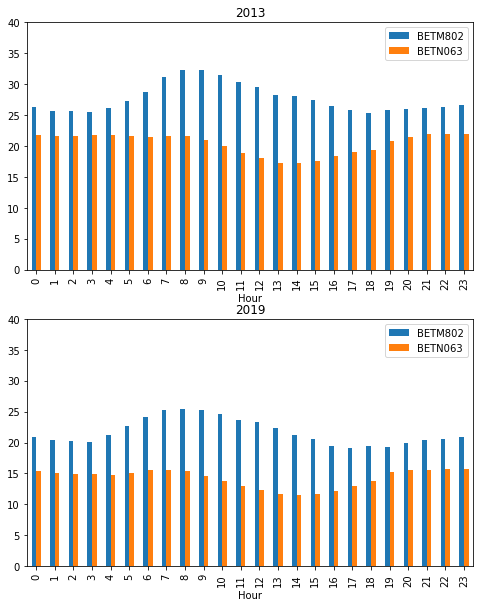

In [72]:
years = [2013,2019]
plt.subplots(figsize=(8, 10))
for id,y in enumerate(years):
    fig = plt.subplot(2, 1, id+1)
    plt.title(y)
    PM10_df[PM10_df.index.year==y].groupby(
        PM10_df[PM10_df.index.year==y].index.hour).mean().plot.bar(ax=fig)
    plt.xlabel('Hour')
    plt.ylim(top=40)

plt.show()

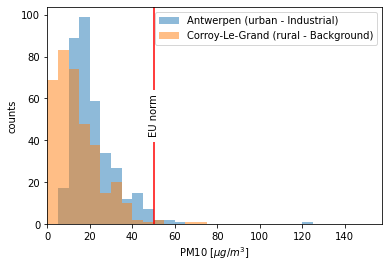

In [75]:
max_pm = 150
th_day = 50
th_year = 40
year = 2019
for s in stations:
    subset = PM10_df_daily[PM10_df_daily.index.year==year][s]
    r = re.search(r' - (.*)', datacq.STATIONS[s]['long_name'])
    place = r.groups()[0]
    #print(subset[subset>th_day].count())
    plt.hist(subset.dropna(),
        bins=30,
        alpha=0.5,
        label=f"{place} ({datacq.STATIONS[s]['description']})",
        range=(0,max_pm),
        density=False)
plt.axvline(x=th_day, color="r")
ax = plt.gca()
y_mid = ax.axes.get_ylim()[1]/2
plt.text(th_day, y_mid, 'EU norm', ha='center', va='center',rotation='vertical', backgroundcolor='white')

#ax.axes.yaxis.set_visible(False)
plt.xlabel(r"PM10 [$\mu g/m^3$]")
plt.ylabel("counts")
plt.xlim(left=0)
plt.legend()
plt.savefig(os.path.join("..","figures",f"PM10_hist_{year}.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)
plt.show()

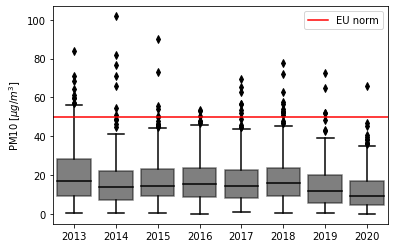

In [202]:
station = 'BETN063'
r = re.search(r' - (.*)', datacq.STATIONS[station]['long_name'])
place = r.groups()[0]

ax = sns.boxplot(data = PM10_df, x='Year',y=station, color='k', boxprops=dict(alpha=.5))
plt.ylabel(r"PM10 [$\mu g/m^3$]")
plt.axhline(y=th_day, color="r", label="EU norm")
plt.xlabel('')
plt.legend()

plt.savefig(os.path.join("..","figures",f"PM10_boxplot_{place}.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)
plt.show()

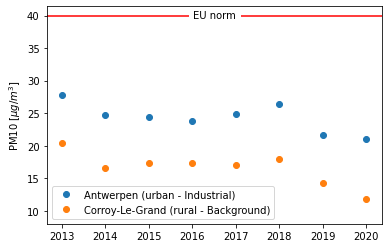

In [206]:
yearly_df = PM10_df.resample('Y').mean()
for s in stations:
    r = re.search(r' - (.*)', datacq.STATIONS[s]['long_name'])
    place = r.groups()[0]
    plt.plot(yearly_df['Year'], yearly_df[s], 'o', label=f"{place} ({datacq.STATIONS[s]['description']})")

PM10_df.resample('Y').mean()
ax = plt.gca()
x_mid = (ax.axes.get_xlim()[1] + ax.axes.get_xlim()[0])/2

plt.text(x_mid, th_year, 'EU norm', ha='center', va='center', backgroundcolor='white')
plt.axhline(y=th_year, color="r")
plt.ylabel(r"PM10 [$\mu g/m^3$]")
plt.ylim(bottom=8)
plt.legend()
plt.savefig(os.path.join("..","figures",f"PM10_trend.png"), 
    facecolor='white', edgecolor='none', bbox_inches='tight', dpi=250)
plt.show()